<a href="https://colab.research.google.com/github/DragosTana/cv_homework/blob/main/Using_pre_trained_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using pre-trained CNN

In this lab, we will see:

- Zero-shot performance of pre-trained backbone
- Use pre-trained CNN as backbone
- Fine-tuning the pre-trained CNN

In [43]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [44]:
batch_size = 64
lr = 0.01
epochs = 40
device = torch.device("cuda") # to use the GPU

In [45]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
# create a split for train/validation. We can use early stop
trainset, valset = torch.utils.data.random_split(dataset, [40000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=False)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=False)


Files already downloaded and verified
Files already downloaded and verified


## Load a pre-defined network with pretrained weights



In [46]:
net = models.resnet18(pretrained=True)
# override the fc layer of the network since it is of 1000 classes by default (ImageNet)
net.fc = nn.Linear(512, 10)
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [47]:
# count the trainable parameters of the model
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_trainable_parameters(net)

11181642

In [48]:
# frozen all the weights of the network, except for fc ones
for param in net.parameters():
    param.requires_grad = False
net.fc.weight.requires_grad = True
net.fc.bias.requires_grad = True
count_trainable_parameters(net)

5130

In [49]:
# define train and test function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        losses.append(loss.item())
    return np.mean(losses)

def test(model, device, test_loader, val=False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    mode = "Val" if val else "Test"
    print('\{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        mode,
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc = correct / len(test_loader.dataset)
    test_loss /= len(test_loader.dataset)
    
    return test_loss, test_acc

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=1e-04)

In [51]:
# the main loop
# train_losses = []
# val_losses = []
# val_accuracies = []
# model_state_dict = None
# 
# for epoch in range(1, epochs + 1):
#     train_loss = train(net, device, trainloader, optimizer, epoch)
#     train_losses.append(train_loss)
#     val_loss, val_acc = test(net, device, valloader)
#     val_losses.append(val_loss)
#     val_accuracies.append(val_acc)

In [52]:
test_loss, test_acc = test(net, device, testloader)

\Test set: Average loss: 384.7668, Accuracy: 925/10000 (9%)



## Add additional layer to the pre-trained model


In [53]:
fc1 = nn.Linear(512, 128)

# Modify the existing fully connected layer (fc)
net.fc = nn.Linear(128, 10)

# Replace the model's classifier with a new sequential layer
# that includes the new fc1 and the modified fc
net.fc = nn.Sequential(
    fc1,
    nn.ReLU(),   # Optional: Add an activation function like ReLU
    net.fc
)
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Fine-tuning some part of the CNN (not only the classifier)

In [54]:
# Unfreeze layer4 parameters
for param in net.layer4.parameters():
    param.requires_grad = True

# Unfreeze fc layer parameters
net.fc.requires_grad = True

# Setting different learning rates
layer4_params = {'params': net.layer4.parameters(), 'lr': 0.001}
fc_params = {'params': net.fc.parameters(), 'lr': 0.1}

# Assuming you are using an Adam optimizer
optimizer = torch.optim.SGD([layer4_params, fc_params], momentum=0.9, weight_decay=1e-04)

## Exercise 1

How many layers it is better to fine-tune?

It is better to update all the weights of the model?

## Exercise 2

Try to change the hyper-parameters of the fine-tuning (e.g. lr of CNN layers and lr of the fc layers) and/or network architecture

## Exercise 3

Try to implement the model selection strategy (also known as early stopping) based on the validation accuracy on cifar10.

Consider using the two following command to respectively save and load the state of all the parameters of the model in a moment.

In [55]:
# save all the parameters of the model
# model_state_dict = net.state_dict()


# the main loop
train_losses = []
val_losses = []
val_accuracies = []
model_state_dict = None
best_val_acc = 0

for epoch in range(1, epochs + 1):
    train_loss = train(net, device, trainloader, optimizer, epoch)
    train_losses.append(train_loss)
    val_loss, val_acc = test(net, device, valloader)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        model_state_dict = net.state_dict()
    
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

Train Epoch: 1 [0/40000 (0%)]	Loss: 2.381930
Train Epoch: 1 [32000/40000 (80%)]	Loss: 1.801429
\Test set: Average loss: 291.6104, Accuracy: 3121/10000 (31%)

Train Epoch: 2 [0/40000 (0%)]	Loss: 1.758461
Train Epoch: 2 [32000/40000 (80%)]	Loss: 1.539238
\Test set: Average loss: 238.4911, Accuracy: 4639/10000 (46%)

Train Epoch: 3 [0/40000 (0%)]	Loss: 1.559373
Train Epoch: 3 [32000/40000 (80%)]	Loss: 1.159348
\Test set: Average loss: 223.5056, Accuracy: 5039/10000 (50%)

Train Epoch: 4 [0/40000 (0%)]	Loss: 1.400780
Train Epoch: 4 [32000/40000 (80%)]	Loss: 1.330528
\Test set: Average loss: 207.1192, Accuracy: 5466/10000 (55%)

Train Epoch: 5 [0/40000 (0%)]	Loss: 1.218806
Train Epoch: 5 [32000/40000 (80%)]	Loss: 1.426605
\Test set: Average loss: 189.5377, Accuracy: 5764/10000 (58%)

Train Epoch: 6 [0/40000 (0%)]	Loss: 1.296709
Train Epoch: 6 [32000/40000 (80%)]	Loss: 0.889901
\Test set: Average loss: 187.0868, Accuracy: 5930/10000 (59%)

Train Epoch: 7 [0/40000 (0%)]	Loss: 1.265329
Train E

In [31]:
# load saved weights on the model
net.load_state_dict(model_state_dict)

<All keys matched successfully>

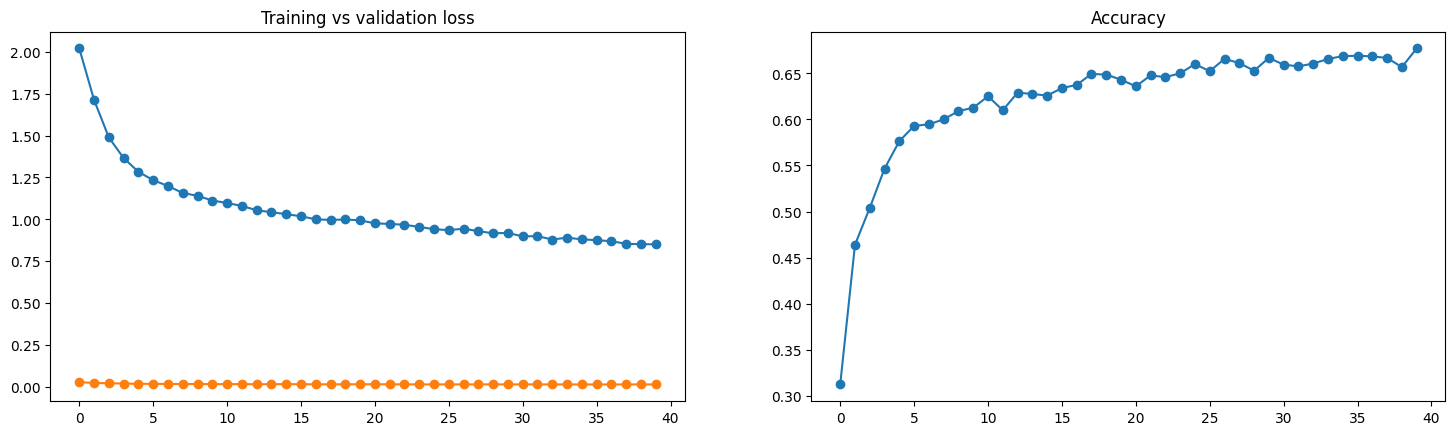

In [56]:
train_losses = np.array(train_losses).ravel()
val_losses = np.array(val_losses).ravel()
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(18)
ax[0].set_title("Training vs validation loss")
ax[1].set_title("Accuracy")
ax[0].plot(np.arange(0, len(train_losses), 1), train_losses, '-o')
ax[0].plot(np.arange(0, len(val_losses), 1), val_losses, '-o')
ax[1].plot(np.arange(0, epochs, 1), val_accuracies, '-o')